In [1]:
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
import json
import csv
import time

def write_to_file(stuff):
    csvFile = open(r'io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

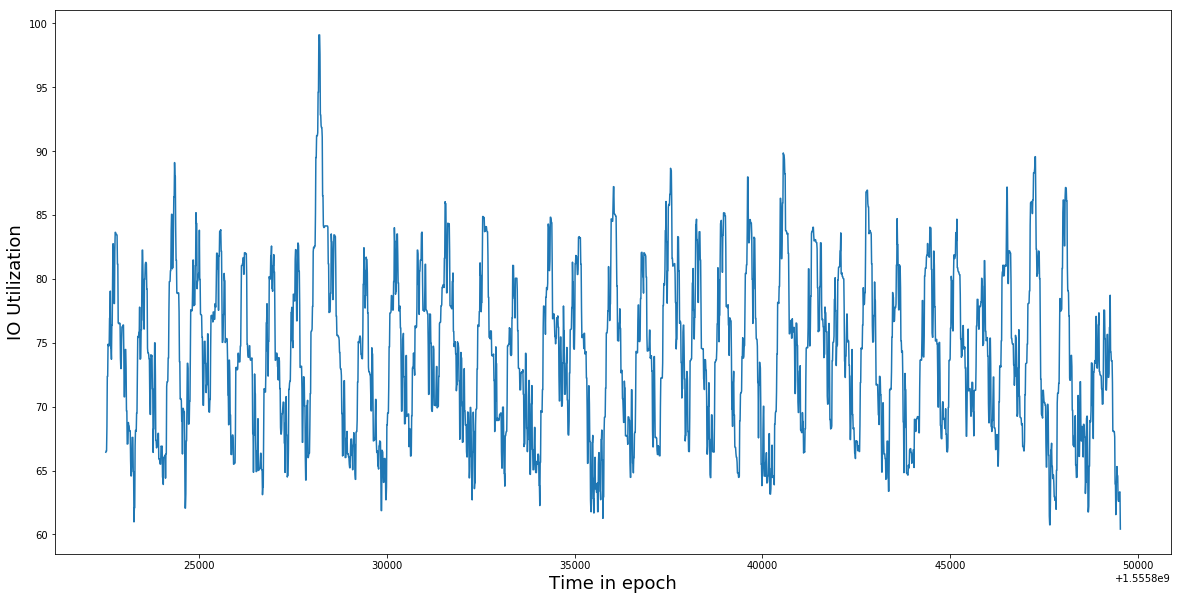

In [2]:
dataframe1 = pd.read_csv('io-util.csv')
x1 = dataframe1['TIME'].tolist()
y1 = dataframe1['UTIL'].tolist()

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [3]:
split_percent = 0.8448
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

420
2281


In [11]:
def wma(Y_Train, law=6):
    Y_Train = Y_Train[-60:]
    prediction = []

    for i in range(law):
        weights = np.arange(1, len(Y_Train) + 1)
        prediction.append(np.sum(Y_Train*weights)/sum(weights))
        Y_Train = np.append(Y_Train, [prediction])
        return prediction

In [12]:
X_Test = []
Y_Test = []
Predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[0 : train_samples + i]
    X_Train = x1[0 : train_samples + i]
    
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])
    Predictions.append(wma(Y_Train)[-1])

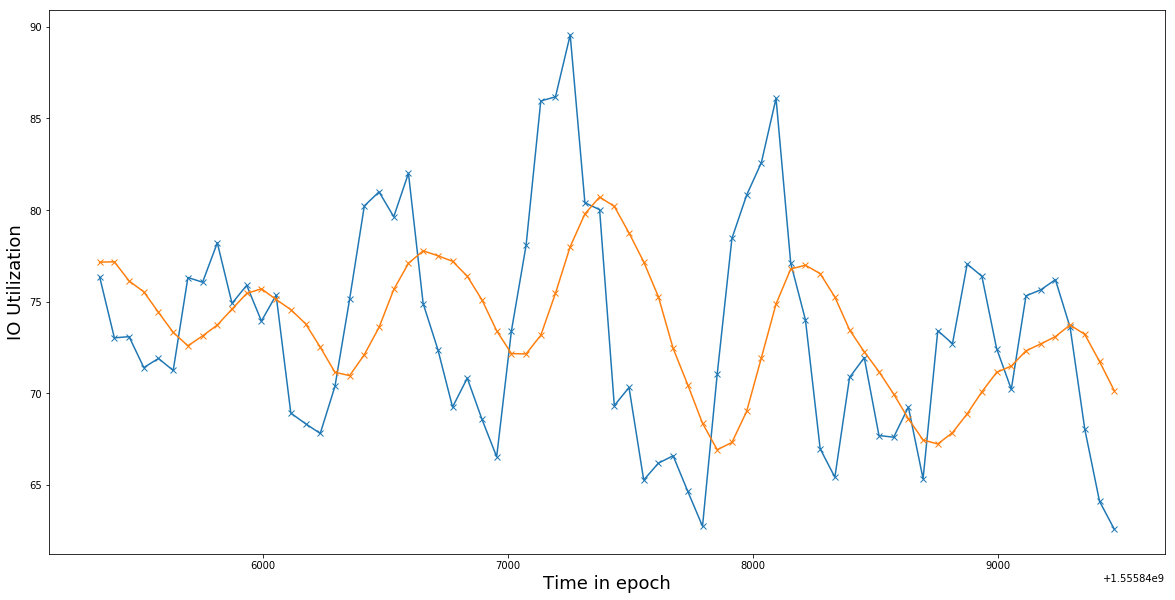

In [13]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Predictions, {'marker': 'x'})

In [14]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
Predictions

[77.15652557889514,
 77.1772819432872,
 76.13080793666975,
 75.5373945064178,
 74.41816232581424,
 73.32403224472175,
 72.59252971611703,
 73.13404185532939,
 73.72609915711071,
 74.59641834866959,
 75.4497182707433,
 75.70419391901773,
 75.1204435103465,
 74.56531262582685,
 73.79787863100374,
 72.51881967213114,
 71.15023065861375,
 70.96405867126833,
 72.11282369859073,
 73.59644060972103,
 75.66491573195282,
 77.09092205924647,
 77.7746241012367,
 77.50675409836066,
 77.20390451538681,
 76.38854184641933,
 75.09687431693989,
 73.41242910555077,
 72.1680092033362,
 72.14916767328155,
 73.16670300014395,
 75.4589245488855,
 78.00148834669233,
 79.78974900961273,
 80.7094494194414,
 80.20065771862916,
 78.74989305931771,
 77.17321103705946,
 75.26622480952214,
 72.45386249695102,
 70.45616787900221,
 68.36431634611097,
 66.92253597195322,
 67.31928973806603,
 69.0139114743772,
 71.9307274633261,
 74.87632947414073,
 76.78547557907434,
 76.98911594019812,
 76.5312886069237,
 75.2575257

In [16]:
mean_absolute_percentage_error(Y_Test, Predictions)

6.874775789732084

# CPU

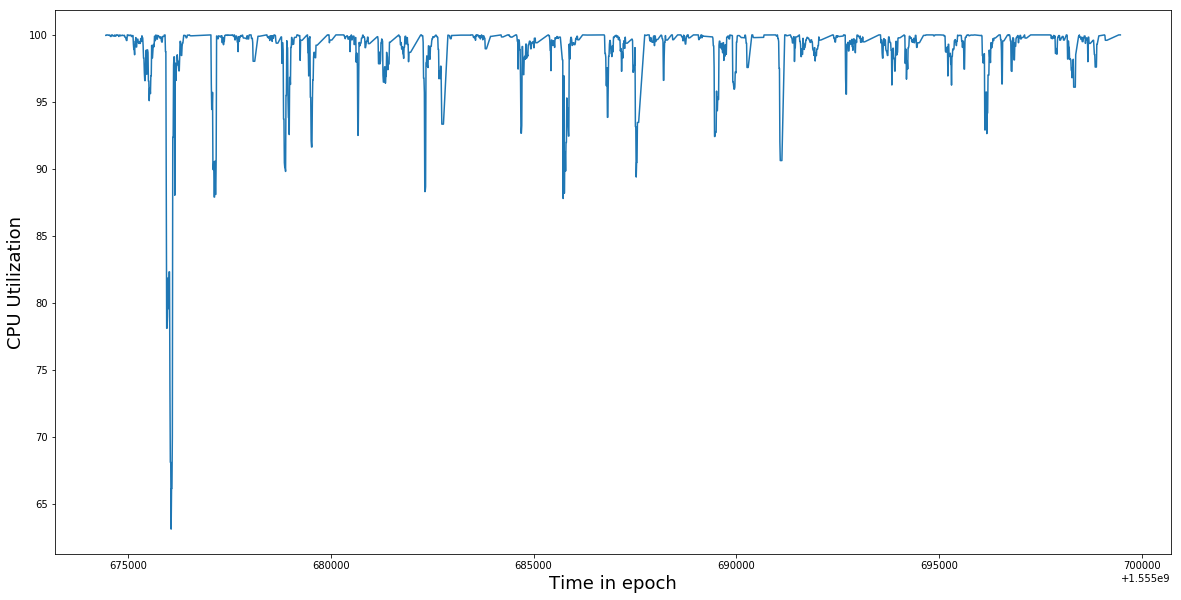

In [118]:
dataframe1 = pd.read_csv('cpu-util-new.csv')
x1 = dataframe1['TIME'].tolist()
y1 = dataframe1['UTIL'].tolist()

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [119]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

347
1385


In [120]:
X_Test = []
Y_Test = []
Predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[0 : train_samples + i]
    X_Train = x1[0 : train_samples + i]
    
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])
    Predictions.append(wma(Y_Train)[-1])

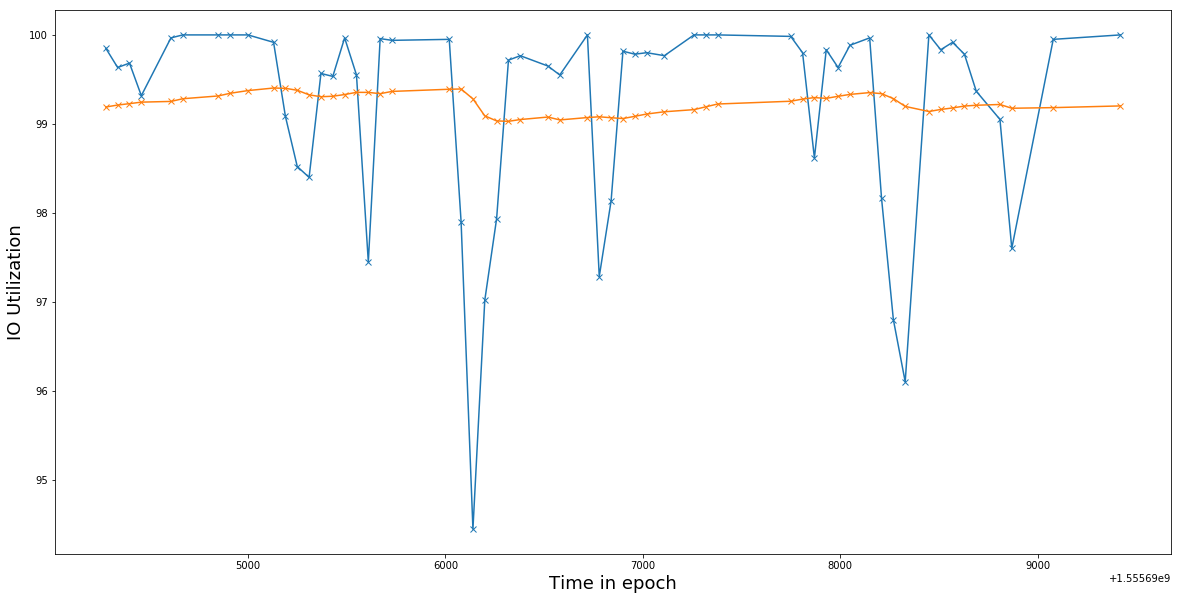

In [121]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Predictions, {'marker': 'x'})

In [122]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
mean_absolute_percentage_error(Y_Test, Predictions)

0.88543308644517

In [127]:
Predictions

[99.1893632723717,
 99.211514695714,
 99.22713341224052,
 99.24412846175215,
 99.25220772709889,
 99.28239649294858,
 99.31383896449032,
 99.34381328475989,
 99.37402062732046,
 99.40295894782122,
 99.39950469245206,
 99.37761786599418,
 99.32631646013488,
 99.30504372671426,
 99.31057299874418,
 99.32960594737408,
 99.35432078369679,
 99.35375892670311,
 99.33925142007973,
 99.36480161367687,
 99.38905754470589,
 99.39205458971905,
 99.28084073777673,
 99.09004476528496,
 99.03300056281819,
 99.02856994519915,
 99.04855059972202,
 99.07661326148524,
 99.0441676589595,
 99.07083935012461,
 99.07950103929075,
 99.06885150204734,
 99.05974691752878,
 99.0846622536221,
 99.11056098512394,
 99.13590592468056,
 99.15999191949317,
 99.19171255201161,
 99.22319477723323,
 99.25424854878905,
 99.27865745410548,
 99.29514217511621,
 99.28681462187367,
 99.30971915017446,
 99.33118822259759,
 99.35141719289118,
 99.33952750568459,
 99.2839277507962,
 99.19622872544251,
 99.13885846694293,
 99.16

# Memory

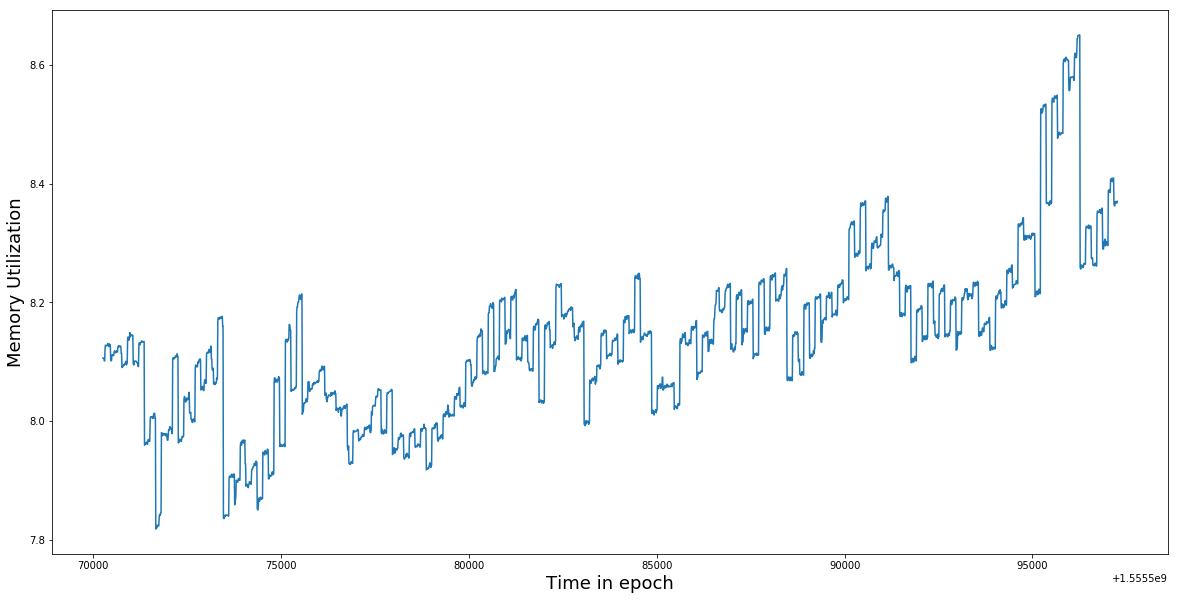

In [98]:
dataframe1 = pd.read_csv('mem-util.csv')
x1 = dataframe1['TIME'].tolist()
y1 = dataframe1['UTIL'].tolist()

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('Memory Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [99]:
split_percent = 0.80
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

541
2160


In [100]:
X_Test = []
Y_Test = []
Predictions = []
for i in range(0, forecast_time, 6):
    Y_Train = y1[0 : train_samples + i]
    X_Train = x1[0 : train_samples + i]
    
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])
    Predictions.append(wma(Y_Train)[-1])

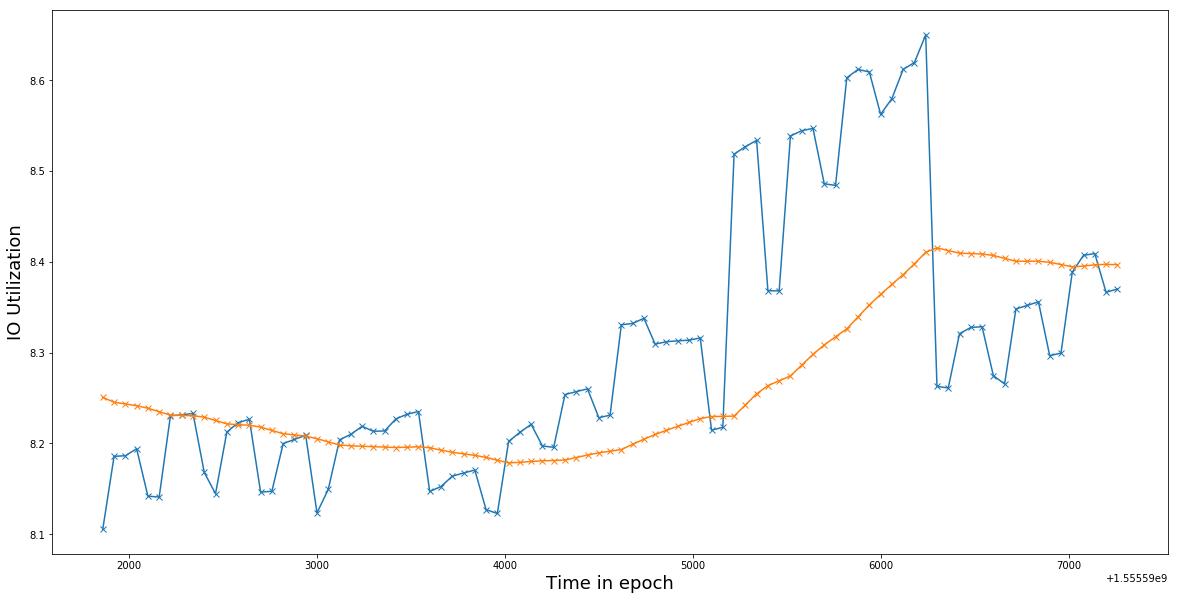

In [101]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Predictions, {'marker': 'x'})

In [102]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [103]:
mean_absolute_percentage_error(Y_Test, Predictions)

1.0530871185410478

In [106]:
Predictions

[8.250658366135298,
 8.245444802524865,
 8.243482545463786,
 8.24160513375851,
 8.238774764191701,
 8.234948350084895,
 8.231152331669296,
 8.230827988699195,
 8.230469538431139,
 8.228939819753233,
 8.22530690544412,
 8.221542334548413,
 8.22067349870819,
 8.220064535212876,
 8.217973265161286,
 8.214277832313117,
 8.210767004028417,
 8.209361005754872,
 8.208086826427113,
 8.205256615983103,
 8.20167944266056,
 8.198348642136075,
 8.197368206733666,
 8.196952580137447,
 8.196465018708206,
 8.196002368897265,
 8.195528873923552,
 8.1958707705658,
 8.196370666978746,
 8.19528054742114,
 8.192635140039553,
 8.190310231868494,
 8.188501232718668,
 8.186897220414503,
 8.184616792729763,
 8.181560175893006,
 8.178614248651781,
 8.179192369833245,
 8.180185058770062,
 8.180879713938719,
 8.181221504319304,
 8.18176302024456,
 8.184489506895883,
 8.187285186074075,
 8.18965367015878,
 8.191447534303023,
 8.193321902717322,
 8.198995763278853,
 8.204699917045726,
 8.209930736579878,
 8.214443